<a href="https://colab.research.google.com/github/cammaral/tn-for-cfd/blob/main/pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install pennylane

In [2]:
# ======================================================
# PINN / QPINN / HPINN demo for 1D Burgers
# ======================================================
import numpy as np
import matplotlib.pyplot as plt
import torch as tc
import torch.nn as nn
import pennylane as qml
from pennylane.qnn import TorchLayer

In [3]:
#========================
# PARAMETERS
#========================

L = 1.0
n = 9
N = 2**n
dx = L / (N - 1)
x = np.linspace(0, L, N)
nu=0.01

T = 0.1
dt = 0.0001
tm = np.arange(0, T + dt, dt)

#========================
# INITIAL u(x,0)
#========================
u0 = np.sin(2 * np.pi * x)

#========================
# DIFFERENTIAL OPERATORS
#========================

D1 = np.zeros((N, N))
for i in range(N):
    D1[i, (i - 1) % N] = -1 / (2 * dx)
    D1[i, (i + 1) % N] =  1 / (2 * dx)

D2 = np.zeros((N, N))
for i in range(N):
    D2[i, i] = -2 / (dx ** 2)
    D2[i, (i - 1) % N] = 1 / (dx ** 2)
    D2[i, (i + 1) % N] = 1 / (dx ** 2)

#========================
# TEMPORAL EVOLUTION
#========================

Nt = len(tm) # number of steps

u = u0.copy()
for step in range(Nt):
    dudx = D1 @ u
    d2udx2 = D2 @ u
    convection = u * dudx  # Hadamard Product
    diffusion = nu * d2udx2
    u = u + dt * (-convection + diffusion) # New ut


In [4]:
# -----------------------------
# Small utilities
# -----------------------------
def t(arr, req=False, dtype=tc.float32):
    return tc.tensor(arr, dtype=dtype, requires_grad=req) # Necessary for derivatives

In [5]:
# -----------------------------
# Architectures
# -----------------------------
class PINN(nn.Module):
    def __init__(self, neurons=5, depth=2, activation=nn.Tanh(), outdim=1):
        super().__init__()
        self.fcs = nn.ModuleList([nn.Linear(2, neurons)])
        self.fcs.extend(nn.Linear(neurons, neurons) for _ in range(depth-1))
        self.out = nn.Linear(neurons, outdim)
        self.act = activation
    def forward(self, xt):
        z = xt
        for fc in self.fcs: z = self.act(fc(z))
        return self.out(z)

class HPINN(nn.Module):
    """Classical pre -> quantum -> classical post to scalar."""
    def __init__(self, n_qubits=2, q_layers=1, pre_neurons=5, pre_depth=2, activation=nn.Tanh()):
        super().__init__()
        pre = [nn.Linear(2, pre_neurons), activation]
        for _ in range(pre_depth-1): pre += [nn.Linear(pre_neurons, pre_neurons), activation]
        pre += [nn.Linear(pre_neurons, n_qubits)]
        self.pre = nn.Sequential(*pre)
        dev = qml.device("default.qubit", wires=n_qubits)
        @qml.qnode(dev, interface="torch")
        def circuit(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(n_qubits))
            qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
        self.quantum = TorchLayer(circuit, {"weights": (q_layers, n_qubits)})
        self.final = nn.Linear(n_qubits, 1)
    def forward(self, xt): return self.final(self.quantum(self.pre(xt)))


In [6]:
# -----------------------------
# PINN training core (shared)
# -----------------------------
def train_burgers(model,
                  x_col, t_col,
                  x_ic, t_ic, u_ic,
                  x_b0, t_b,  u_b0,
                  x_bL, t_bL, u_bL,
                  nu=1, lr=1e-3, epochs=100,
                  weights=(1.0, 1.0, 1.0, 1.0)):
    """Train any model f((x,t)) -> u with PDE+IC+BC losses (classic PINN loop)."""
    w_pde, w_ic, w_b0, w_bL = weights
    opt = tc.optim.Adam(model.parameters(), lr=lr)
    loss_history = []

    for _ in range(epochs):
        u = model(tc.cat([x_col, t_col], dim=1))
        du_dt   = tc.autograd.grad(u, t_col, grad_outputs=tc.ones_like(u), create_graph=True)[0]
        du_dx   = tc.autograd.grad(u, x_col, grad_outputs=tc.ones_like(u), create_graph=True)[0]
        d2u_dx2 = tc.autograd.grad(du_dx, x_col, grad_outputs=tc.ones_like(u), create_graph=True)[0]
        pde = du_dt + u*du_dx - nu*d2u_dx2
        loss_pde = tc.mean(pde**2)

        loss_ic  = tc.mean((model(tc.cat([x_ic, t_ic], dim=1)) - u_ic)**2)
        loss_b0  = tc.mean((model(tc.cat([x_b0, t_b ], dim=1)) - u_b0)**2)
        loss_bL  = tc.mean((model(tc.cat([x_bL, t_bL], dim=1)) - u_bL)**2)

        loss = w_pde*loss_pde + w_ic*loss_ic + w_b0*loss_b0 + w_bL*loss_bL

        opt.zero_grad(); loss.backward(); opt.step()

        # salvar a loss em float
        loss_history.append(loss.item())

    return model, loss_history

def predict(model, x_vec, t_val):
    """Return u(x, t=t_val) as numpy array."""
    x = t(x_vec, False); tfix = t(np.full_like(x_vec, t_val), False)
    with tc.no_grad(): return model(tc.cat([x, tfix], dim=1)).cpu().numpy().reshape(-1,1)

In [11]:
# -----------------------------
# Toy data for 1D Burgers
# -----------------------------
L, Tfin = 1.0, 0.1
dx = L / (N-1)
dt = Tfin / (N-1)

# Initial condition: u(x,0) = sin(pi x)
x_ic = np.linspace(0, L, N).reshape(-1,1)
t_ic = np.zeros_like(x_ic)
u_ic = np.sin(2 * np.pi * x_ic)

# Dirichlet boundaries: u(0,t)=u(L,t)=0
t_b  = np.linspace(0, Tfin, N).reshape(-1,1)
x_b0, x_bL = np.zeros_like(t_b), L*np.ones_like(t_b)
u_b0, u_bL = np.zeros_like(t_b), np.zeros_like(t_b)

# Random collocation points
x_col = np.random.rand(N,1)*L
t_col = np.random.rand(N,1)*Tfin

# Tensors with autograd for x,t
x_col = t(x_col, True); t_col = t(t_col, True)
x_ic  = t(x_ic,  True); t_ic = t(t_ic,  True); u_ic = t(u_ic)
x_b0  = t(x_b0, True);  t_b  = t(t_b,  True);  u_b0 = t(u_b0)
x_bL  = t(x_bL, True);  t_bL = t_b;            u_bL = t(u_bL)

# -----------------------------
# Parameters
# -----------------------------
epochs = 1000
lr = 1e-2
activation=nn.Tanh()
x_plot = np.linspace(0, L, 100).reshape(-1,1)


In [12]:
# -----------------------------
# Train & plot: PINN
# -----------------------------
tc.manual_seed(42)
pinn = PINN(neurons=10, depth=4, activation=activation)
pinn, loss_hist = train_burgers(pinn, x_col, t_col, x_ic, t_ic, u_ic,
                                x_b0, t_b, u_b0, x_bL, t_bL, u_bL,
                                nu=nu, lr=lr, epochs=1000)

u_pinn = predict(pinn, x_plot, 0.1)
# -----------------------------
# Train & plot: HPINN
# -----------------------------
hpinn = HPINN(n_qubits=4, q_layers=3, pre_neurons=10, pre_depth=4, activation=activation)
hpinn, hloss_hist = train_burgers(hpinn, x_col, t_col, x_ic, t_ic, u_ic, x_b0, t_b, u_b0, x_bL, t_bL, u_bL,
                      nu=nu, lr=lr, epochs=epochs)

u_hpinn = predict(hpinn, x_plot, 0.1)

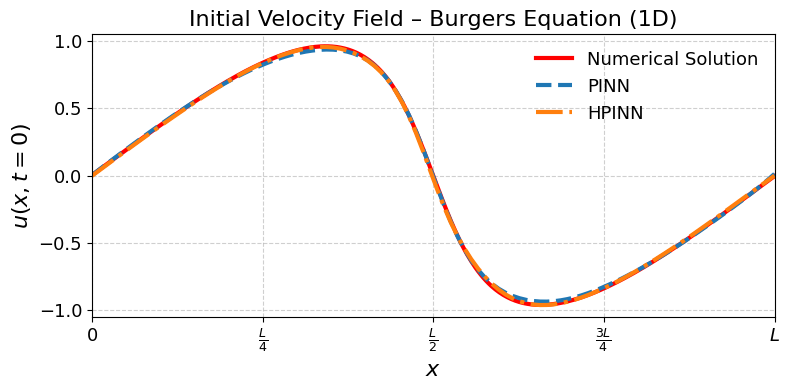

In [17]:
#========================
# PLOT - u(x,0) and u(x,T)
#========================

tick_positions = np.linspace(0, L, 5)
tick_labels = [r"$0$", r"$\frac{L}{4}$", r"$\frac{L}{2}$", r"$\frac{3L}{4}$", r"$L$"]

plt.figure(figsize=(8, 4))
#plt.plot(x, u0, lw=3, c='darkorange', label='$u_0$')
plt.plot(x, u, lw=3, c='red', label='Numerical Solution')
plt.plot(x_plot, u_pinn, linewidth=3.0, ls='--', label='PINN')
plt.plot(x_plot, u_hpinn, linewidth=3.0, ls='-.', label='HPINN')

plt.xlim(0, L)
plt.ylim(-1.05, 1.05)

plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$u(x, t=0)$', fontsize=16)
plt.title('Initial Velocity Field – Burgers Equation (1D)', fontsize=16)

plt.xticks(tick_positions, tick_labels, fontsize=13)
plt.yticks(np.linspace(-1, 1, 5),fontsize=13)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=13, frameon=False)
plt.tight_layout()
plt.show()


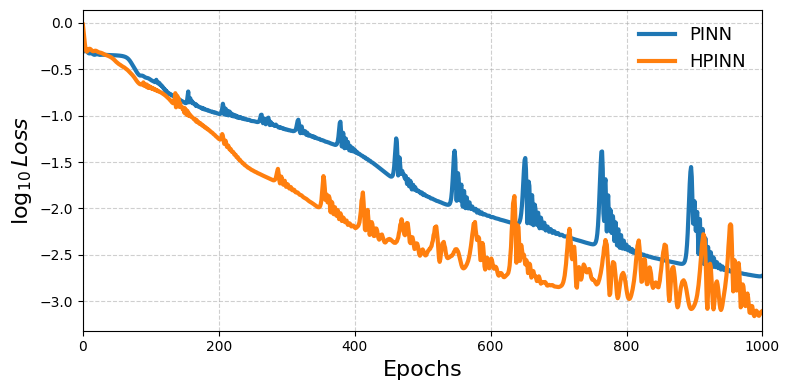

In [14]:
#========================
# PLOT - loss
#========================

plt.figure(figsize=(8, 4))

plt.plot(np.log10(loss_hist), linewidth=3.0, label='PINN')
plt.plot(np.log10(hloss_hist), linewidth=3.0, label='HPINN')

plt.xlim(0, epochs)

plt.xlabel(r'Epochs', fontsize=16)
plt.ylabel(r'$\log_{10}Loss$', fontsize=16)


plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=13, frameon=False)
plt.tight_layout()
plt.show()


In [15]:
# Número total de parâmetros treináveis
print("PINN parâmetros:", sum(p.numel() for p in pinn.parameters() if p.requires_grad))
print("HPINN parâmetros:", sum(p.numel() for p in hpinn.parameters() if p.requires_grad))

# Se quiser ver por camada
for name, param in pinn.named_parameters():
    print(name, param.shape, param.numel())

for name, param in hpinn.named_parameters():
    print(name, param.shape, param.numel())


PINN parâmetros: 371
HPINN parâmetros: 421
fcs.0.weight torch.Size([10, 2]) 20
fcs.0.bias torch.Size([10]) 10
fcs.1.weight torch.Size([10, 10]) 100
fcs.1.bias torch.Size([10]) 10
fcs.2.weight torch.Size([10, 10]) 100
fcs.2.bias torch.Size([10]) 10
fcs.3.weight torch.Size([10, 10]) 100
fcs.3.bias torch.Size([10]) 10
out.weight torch.Size([1, 10]) 10
out.bias torch.Size([1]) 1
pre.0.weight torch.Size([10, 2]) 20
pre.0.bias torch.Size([10]) 10
pre.2.weight torch.Size([10, 10]) 100
pre.2.bias torch.Size([10]) 10
pre.4.weight torch.Size([10, 10]) 100
pre.4.bias torch.Size([10]) 10
pre.6.weight torch.Size([10, 10]) 100
pre.6.bias torch.Size([10]) 10
pre.8.weight torch.Size([4, 10]) 40
pre.8.bias torch.Size([4]) 4
quantum.weights torch.Size([3, 4]) 12
final.weight torch.Size([1, 4]) 4
final.bias torch.Size([1]) 1
